### 脚本使用说明

0. 数据集准备

    请在项目根目录下创建`img`目录，并在其中创建`src_img`、`test_img`、`encoded_img`、`decoded_img`四个目录，将kodok数据集放在`src_img`目录下，最终结构如下所示：

      ```python
      img
      ├─decoded_img
      ├─encoded_img
      ├─src_img
      │  │
      │  └─kodok
      │          kodim01.png
      │          kodim02.png
      │          kodim03.png
      │          ...
      │
      └─test_img
      ```

1. 安装

   - 本项目使用 Python 3.9，推荐使用 Miniconda 或 Anaconda 创建一个虚拟环境：`conda create -n ic python=3.9 -y`，其中`-n`参数后的`ic`是可以修改的，表示创建的虚拟环境的名称。
   - 激活虚拟环境：`conda activate ic`，与上一条命令中的ic保持一致，如果ic修改为其他名字，则这里也需要修改为对应的名称。
   - 安装本项目所需的依赖包： `pip install -r requirements.txt`。

2. 使用

   - 如果需要运行 GUI 软件，请在windows环境下或具有桌面的linux下使用命令：`python main.py`。
   - 如果需要查看代码运行案例，请查看 `explain.ipynb` notebook 文件。

### 0.导包

导入所需的依赖包：标准库、第三方库、自定义库

In [34]:
# 标准库
import os
import sys
import time
from pprint import pprint
from pathlib import Path
# 类型标注
from typing import List, Dict, Tuple, Union, Optional, Iterable, Callable, Any, NoReturn

# 第三方库
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import structural_similarity as SSIM, peak_signal_noise_ratio as PSNR

# 自定义库
from src.core.Encoder import Encoder, JP2KEncoder as MYJPEncoder
from src.core.Decoder import Decoder, JP2KDecoder as MYJPDecoder
# 路径配置
from src.config_.path_config import SRC_IMG_ROOT


### 1.定义评价指标计算函数

主要评价指标包括PSNR和SSMI值，计算bpp用于绘制PSNR-bpp和SSMI-bpp图。

In [35]:
def bpp(file_size: int, image_size: Iterable) -> float:
    """
    根据给定的文件大小和图片尺寸，计算bpp的值
    :param file_size: int 文件大小
    :param image_size: 图片的形状尺寸，至少包含h和w，如果是彩色图像则还需要通道c
    """
    if len(image_size) == 3:
        h, w, c = image_size
        bpp_value = file_size / (h * w * c)
    else:
        h, w = image_size
        bpp_value = file_size / (h * w)
    return bpp_value

### 2.读取图像文件名列表

In [36]:
# kodok数据集图片路径，SRC_IMG_ROOT 与其他常量路径配置在 src.config_.path_config.py 中
KODOK_ROOT = SRC_IMG_ROOT / "kodok"
# 获得数据集图片的绝对路径列表
kodok_list = os.listdir(KODOK_ROOT)
kodok_list = [KODOK_ROOT / filename for filename in kodok_list]

pprint(kodok_list[:5])

[WindowsPath('D:/Project/MyProjects/JP2K_System/img/src_img/kodok/kodim01.png'),
 WindowsPath('D:/Project/MyProjects/JP2K_System/img/src_img/kodok/kodim02.png'),
 WindowsPath('D:/Project/MyProjects/JP2K_System/img/src_img/kodok/kodim03.png'),
 WindowsPath('D:/Project/MyProjects/JP2K_System/img/src_img/kodok/kodim04.png'),
 WindowsPath('D:/Project/MyProjects/JP2K_System/img/src_img/kodok/kodim05.png')]


### 3.从kodok数据集计算绘图数据

求出同一个量化系数下，每张图的压缩后的psnr值、ssmi值、bpp值，然后求平均值

In [42]:
def calculate(img_path: str, q_factor: int,
              encoder: Encoder=MYJPEncoder(), decoder:Decoder=MYJPDecoder()
              ) -> Tuple[float, float, float, float, float]:
    """
    计算给定图像在使用自定义的编解码器时的bpp值、psnr值、ssim值，编码花费时间和解码花费的时间。
    :param img_path: str 给定的图像路径
    :param q_factor: int 量化系数，越大质量越差
    :param encoder: Encoder 编码器对象，如果不提供则创建一个
    :param decoder: Decoder 解码器对象，如果不提供则创建一个
    :return: Tuple 包含了bpp、psnr、ssim值以及编解码所花费的时间
    """
    # 设置量化系数
    encoder.q_factor = q_factor
    decoder.q_factor = q_factor

    # 读取图像数据
    src_img = encoder.read(img_path)
    
    # 对图像数据编码
    start = time.time()
    src_bitstream = encoder.encode(src_img)
    encode_time = time.time() - start

    # 对图像数据进行解码
    start = time.time()
    decoded_img = decoder.decode(src_bitstream)
    decode_time = time.time() - start

    # 如果解码的尺寸颠倒，则转置一下宽高
    if src_img.shape[0] != decoded_img.shape[0]:
        decoded_img = np.transpose(decoded_img, (1, 0, 2))

    # 计算psnr、ssim和bpp
    psnr_value = PSNR(src_img, decoded_img)
    ssim_value = SSIM(src_img, decoded_img, channel_axis=2)
    file_size = sys.getsizeof(src_bitstream)
    bpp_value = bpp(file_size, decoded_img.shape) 
    return bpp_value, psnr_value, ssim_value, encode_time, decode_time

def calculate_jpeg(img_path: str, quality: int
                   ) -> Tuple[float, float, float, float, float]:
    """
    计算给定图像在使用JPEG标准的编解码器时的bpp值、psnr值、ssim值，编码花费时间和解码花费的时间。
    :param img_path: str 给定的图像路径
    :param quality: int 质量参数，越大质量越好
    :return: Tuple 包含了bpp、psnr、ssim值以及编解码所花费的时间
    """
    # 读取图像数据
    src_img = Image.open(str(img_path))
    
    # 准备存储路径
    TEST_PATH = img_path.parent.parent.parent / "test_img"
    if not TEST_PATH.exists():
        TEST_PATH.touch()
    output_path = TEST_PATH / f"{img_path.stem}.jpg"

    # JPEG编码
    start = time.time()
    src_img.save(output_path, 'JPEG', quality=quality)
    encode_time = time.time() - start

    # JPEG解码
    start = time.time()
    _ = Image.open(str(output_path))
    decode_time = time.time() - start

    # 准备图像数据
    src_img = cv2.imread(img_path)
    decoded_img = cv2.imread(output_path)

    # 计算psnr、ssim和bpp值
    psnr_value = PSNR(src_img, decoded_img)
    ssim_value = SSIM(src_img, decoded_img, channel_axis=2)
    file_size = os.path.getsize(output_path) * 8
    bpp_value = bpp(file_size, decoded_img.shape)
    return bpp_value, psnr_value, ssim_value, encode_time, decode_time

In [38]:
def get_data(calculate_func: Callable, path_list: List[Path], q_factor: int, 
             **kwargs: Dict[str, Any]
             ) -> Tuple[List[float], List[float], List[float], List[float], List[float]]:
    """
    根据提供的计算函数和量化系数或质量参数，
    计算提供的一系列图片的bpp、psnr、ssim值和编解码时间并返回。
    :param calculat_func: Callable 提供的计算函数，
        要求至少接收一个图片路径和量化系数（或质量参数），
        并返回5个float值（bpp、psnr、ssim、encode_time、decode_time）
    :param path_list: List[Path] 图片路径的列表
    :param q_factor: int 量化系数或质量参数
    :param **kwargs: Dict[str, Any] 提供给计算函数的其他关键字参数
    :return: Tuple 返回记录了path_list提供的每张图片的bpp、psnr、ssim和编解码时间的5个列表
    """
    bpp_list, psnr_list, ssim_list = [], [], []
    encode_times, decode_times = [], []
    for file_path in path_list:
        # 计算结果
        bpp_v, psnr_v, ssim_v, encode_time, decode_time = calculate_func(file_path, q_factor, **kwargs)
        # 记录数据
        bpp_list.append(bpp_v)
        psnr_list.append(psnr_v)
        ssim_list.append(ssim_v)
        encode_times.append(encode_time)
        decode_times.append(decode_time)
    return bpp_list, psnr_list, ssim_list, encode_times, decode_times
    

In [47]:
# 定义自定义的编解码器对象
encoder = MYJPEncoder(tile_size=128)
decoder = MYJPDecoder(tile_size=128)

# 指定量化系数和质量参数的列表
factor_list = range(10, 70, 10)

# 用于记录自定义编解码器的数据
my_metrics = {
    "bpp": [],
    "psnr": [],
    "ssim": [],
    "encode_time": [],
    "decode_time": []
}

# 用于记录JPEG编解码器的数据
jpeg_metrics = {
    "bpp": [],
    "psnr": [],
    "ssim": [],
    "encode_time": [],
    "decode_time": []
}

# 计算平均值的函数（也许定义成lambda更合适）
def avg(num_list):
    return sum(num_list) / len(num_list)

# 每一个量化系数或质量参数，计算一次kodok数据集的平均值
for q_factor in factor_list:
    # MYJP
    bpp_list, psnr_list, ssim_list, encode_times, decode_times = get_data(calculate, kodok_list, q_factor, encoder=encoder, decoder=decoder)
    my_metrics["bpp"].append(avg(bpp_list))
    my_metrics["psnr"].append(avg(psnr_list))
    my_metrics["ssim"].append(avg(ssim_list))
    my_metrics["encode_time"].append(avg(encode_times))
    my_metrics["decode_time"].append(avg(decode_times))
    # JPEG
    bpp_list, psnr_list, ssim_list, encode_times, decode_times = get_data(calculate_jpeg, kodok_list, q_factor)
    jpeg_metrics["bpp"].append(avg(bpp_list))
    jpeg_metrics["psnr"].append(avg(psnr_list))
    jpeg_metrics["ssim"].append(avg(ssim_list))
    jpeg_metrics["encode_time"].append(avg(encode_times))
    jpeg_metrics["decode_time"].append(avg(decode_times))

In [ ]:
pprint(my_metrics)

{'bpp': [0.276815343786169,
         0.22627597384982642,
         0.20500988430447045,
         0.19221637867115168,
         0.18432320488823783,
         0.1769852814850984],
 'decode_time': [0.23746717969576517,
                 0.20302383104960123,
                 0.17055559158325195,
                 0.15832982460657755,
                 0.15414118766784668,
                 0.15062522888183594],
 'encode_time': [0.21465545892715454,
                 0.20041788617769876,
                 0.17114916443824768,
                 0.16410169998804727,
                 0.16445701320966086,
                 0.16314620772997537],
 'psnr': [29.958556911953067,
          23.006832226482967,
          24.86174800031033,
          18.75113338410343,
          21.916095859487566,
          19.29306924180589],
 'ssim': [0.7814688941096114,
          0.7188749932652886,
          0.6935612725947421,
          0.6214769646879706,
          0.632305237424888,
          0.5911722451013722]}


### 4.根据数据绘制PSNR-bpp图和SSIM-bpp图

In [53]:
def draw_line(x_data_lists: List[List[float]], y_data_lists: List[List[float]], line_label_lists: List[str], 
              title: str, xlabel: str, ylabel: str, 
              marker_list: Optional[List[str]]=None, color_list: Optional[List[str]]=None,
              xlim: Optional[Tuple[float, float]]=None, ylim: Optional[Tuple[float, float]]=None) -> NoReturn:
    """
    绘图封装，可以指定绘制多条折线
    :param x_data_lists: List[List[float]] x轴数据列表的列表, 每一个元素都是一条折线的所有x轴数据
    :param y_data_lists: List[List[float]] y轴数据列表的列表, 每一个元素都是一条折线的所有y轴数据
    :param line_label_lists: List[str] 每一条折线的名称列表
    :param title: str 图像的标题
    :param xlabel: str x轴的标签名
    :param ylabel: str y轴的标签名
    :param marker_list: List[str] 数据点的显示类型列表，默认值全为正方形打点，具体可选项请参考matplotlib文档
    :param color_list: List[str] 颜色的类型列表，默认值全为蓝色，具体可选项请参考matplotlib文档
    :param xlim: Tuple[float, float] 指定x轴的展示范围
    :param ylim: Tuple[float, float] 指定y轴的展示范围
    """
    data_num = len(x_data_lists)
    if not marker_list:
        marker_list = ["o"] * data_num
    if not color_list:
        color_list = ["b"] * data_num
    plt.figure(figsize=(10, 6))
    for i in range(data_num):
        plt.plot(x_data_lists[i], y_data_lists[i], label=line_label_lists[i],
                 marker=marker_list[i],
                 color=color_list[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if not xlim:
        plt.xlim(xlim)
    if not ylim:
        plt.ylim(ylim)
    plt.grid(True)
    plt.title(title)
    plt.legend()
    plt.show()


绘图：

1. 自定义编码器的 encode_time-bpp图、decode_time-bpp图、PSNR-bpp图、SSIM-bpp图 值
2. JPEG编码的 PSNR-bpp图、SSIM-bpp图 值

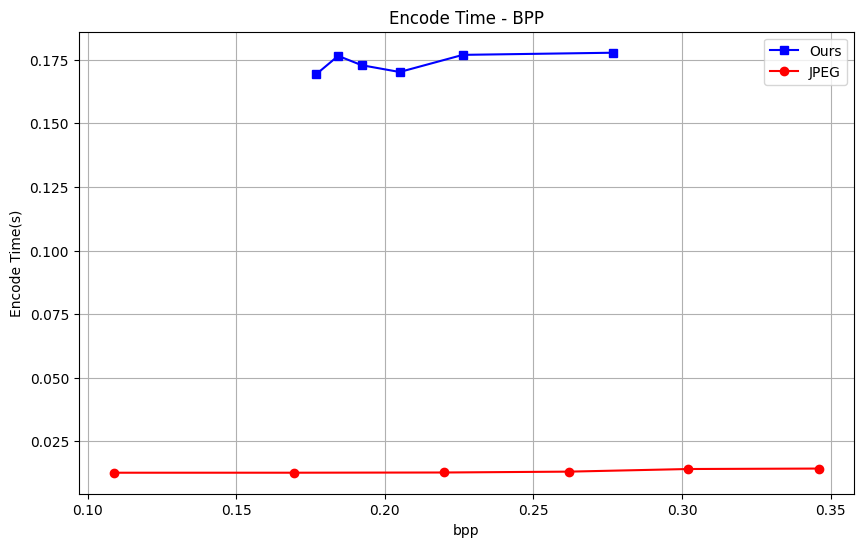

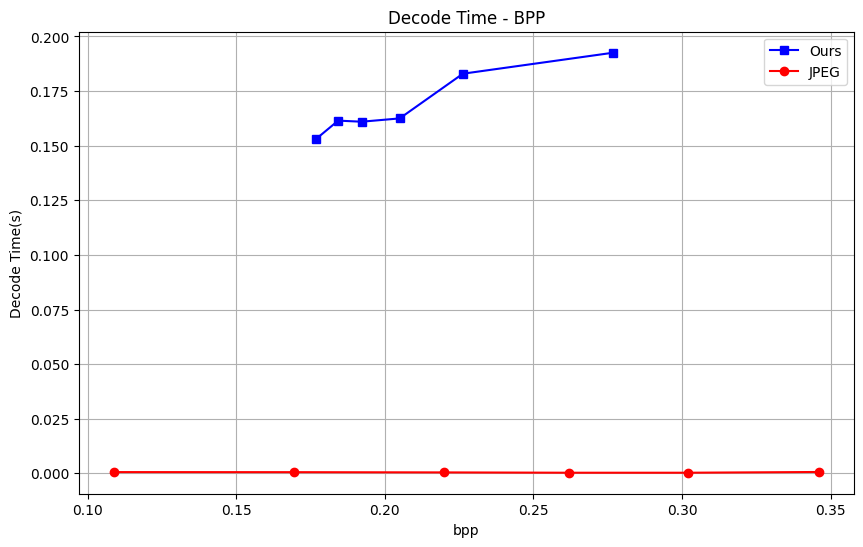

In [61]:
# 计算 bpp 的显示上下界
bpp_scale = (max(my_metrics["bpp"]) - min(my_metrics["bpp"]))/4
bpp_lim = (min(my_metrics["bpp"]) - bpp_scale, max(my_metrics["bpp"]) + bpp_scale)

# 计算 Encode Time 的显示上下界
encode_time_scale = (max(my_metrics["encode_time"]) - min(my_metrics["encode_time"]))/4
encode_time_lim = (min(my_metrics["encode_time"]) - encode_time_scale, max(my_metrics["encode_time"]) + encode_time_scale)

# 计算 Decode Time 的显示上下界
decode_time_scale = (max(my_metrics["decode_time"]) - min(my_metrics["decode_time"]))/4
decode_time_lim = (min(my_metrics["decode_time"]) - decode_time_scale, max(my_metrics["decode_time"]) + decode_time_scale)

# 绘制 Encode Time - bpp 图
draw_line(
    x_data_lists=[my_metrics["bpp"], jpeg_metrics["bpp"]], 
    y_data_lists=[my_metrics["encode_time"], jpeg_metrics["encode_time"]], 
    line_label_lists=["Ours", "JPEG"],
    marker_list=["s", "o"],
    color_list=["b", "r"],
    title="Encode Time - BPP",
    xlabel="bpp",
    ylabel="Encode Time(s)",
    xlim=bpp_lim,
    ylim=encode_time_lim
    )
# 绘制 Decode Time - bpp 图
draw_line(
    x_data_lists=[my_metrics["bpp"], jpeg_metrics["bpp"]], 
    y_data_lists=[my_metrics["decode_time"], jpeg_metrics["decode_time"]], 
    line_label_lists=["Ours", "JPEG"],
    marker_list=["s", "o"],
    color_list=["b", "r"],
    title="Decode Time - BPP",
    xlabel="bpp",
    ylabel="Decode Time(s)",
    xlim=bpp_lim,
    ylim=decode_time_lim
    )


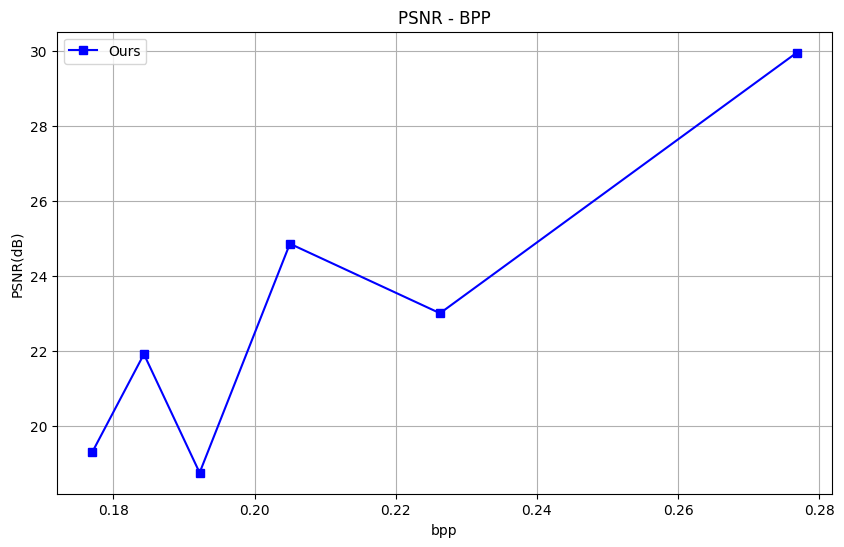

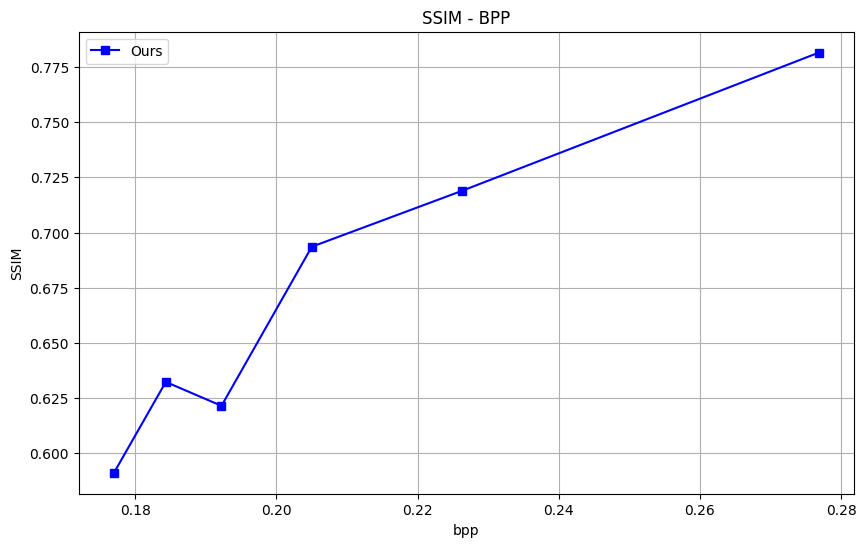

In [60]:
# 计算 PSNR 的显示上下界
psnr_scale = (max(my_metrics["psnr"]) - min(my_metrics["psnr"]))/4
psnr_lim = (min(my_metrics["psnr"]) - psnr_scale, max(my_metrics["psnr"]) + psnr_scale)

# 计算 SSIM 的显示上下界
ssim_scale = (max(my_metrics["ssim"]) - min(my_metrics["ssim"]))/4
ssim_lim = (min(my_metrics["ssim"]) - ssim_scale, max(my_metrics["ssim"]) + ssim_scale)

# 绘制 PSNR - bpp 图
draw_line(
    x_data_lists=[my_metrics["bpp"]], 
    y_data_lists=[my_metrics["psnr"]], 
    line_label_lists=["Ours"],
    marker_list=["s"],
    color_list=["b"],
    title="PSNR - BPP",
    xlabel="bpp", ylabel="PSNR(dB)",
    xlim=bpp_lim, ylim=psnr_lim
    )
# 绘制 SSIM - bpp 图
draw_line(
    x_data_lists=[my_metrics["bpp"]], 
    y_data_lists=[my_metrics["ssim"]], 
    line_label_lists=["Ours"],
    marker_list=["s"],
    color_list=["b"],
    title="SSIM - BPP",
    xlabel="bpp", ylabel="SSIM",
    xlim=bpp_lim, ylim=ssim_lim
    )


同时绘制自定义编码器和JPEG标准的 PSNR-bpp图 和 SSIM-bpp图

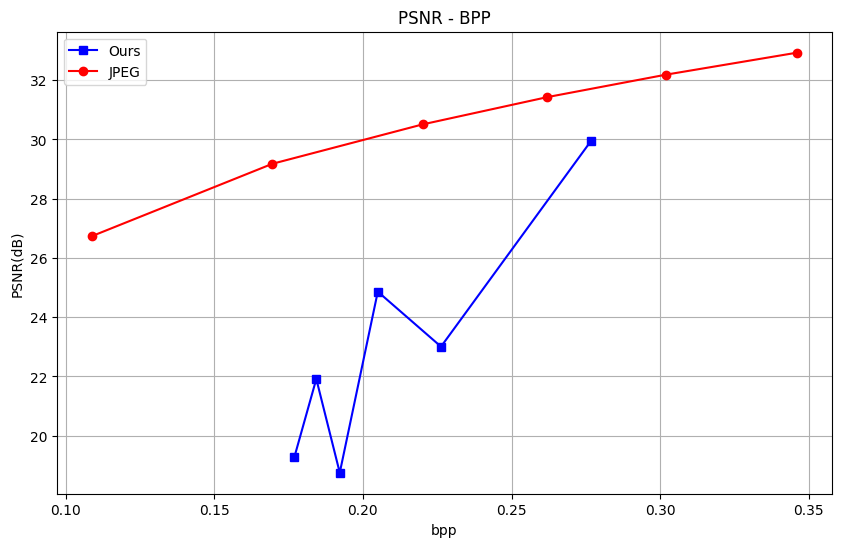

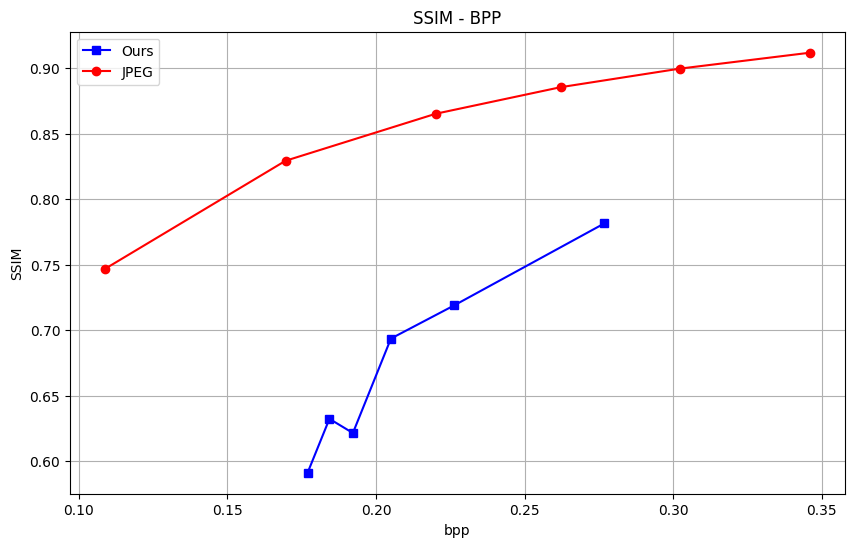

In [59]:
# 计算所有折线的bpp显示范围
merge_bpp = my_metrics["bpp"] + jpeg_metrics["bpp"]
bpp_scale = (max(merge_bpp) - min(merge_bpp))/4
bpp_lim = (min(merge_bpp)-bpp_scale, max(merge_bpp)+bpp_scale)

# 计算所有折线的psnr显示范围
merge_psnr = my_metrics["psnr"] + jpeg_metrics["psnr"]
psnr_scale = (max(merge_psnr) - min(merge_psnr))/4
psnr_lim = (min(merge_psnr)-psnr_scale, max(merge_psnr)+psnr_scale)

# 计算所有折线的ssim显示范围
merge_ssim = my_metrics["ssim"] + jpeg_metrics["ssim"]
ssim_scale = (max(merge_ssim) - min(merge_ssim))/4
ssim_lim = (min(merge_ssim)-ssim_scale, max(merge_ssim)+ssim_scale)

# 绘制 PSNR - bpp 图
draw_line(
    x_data_lists=[my_metrics["bpp"], jpeg_metrics["bpp"]], 
    y_data_lists=[my_metrics["psnr"], jpeg_metrics["psnr"]], 
    line_label_lists=["Ours", "JPEG"],
    marker_list=["s", "o"],
    color_list=["b", "r"],
    title="PSNR - BPP",
    xlabel="bpp", ylabel="PSNR(dB)",
    xlim=bpp_lim, ylim=psnr_lim
    )
# 绘制 SSIM - bpp 图
draw_line(
    x_data_lists=[my_metrics["bpp"], jpeg_metrics["bpp"]], 
    y_data_lists=[my_metrics["ssim"], jpeg_metrics["ssim"]], 
    line_label_lists=["Ours", "JPEG"],
    marker_list=["s", "o"],
    color_list=["b", "r"],
    title="SSIM - BPP",
    xlabel="bpp", ylabel="SSIM",
    xlim=bpp_lim, ylim=ssim_lim
    )
